In [3]:
import tweepy
from tweepy import API 
from tweepy import Stream
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener
from datetime import date, timedelta
import json
import pandas as pd
import csv
import re #regular expression
from textblob import TextBlob
import string
import preprocessor as p
import os
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
#import tweet-preprocessor


In [4]:
auth = OAuthHandler("XXX", "XXX")
auth.set_access_token('XXX', "XXX")
api = tweepy.API(auth)

In [9]:
from datetime import datetime, timedelta
start_date = date.today() - timedelta(days= 7)

print(start_date)

2020-03-03


In [10]:
keywords =  """ #corona Virus OR #Wuhan """

In [11]:
tweets = tweepy.Cursor(api.search,q=keywords,since=start_date).items(500)

users_locs = [[tweet.created_at, tweet.user.screen_name, tweet.retweet_count, tweet.favorite_count, tweet.text, tweet.user.location,tweet.id ] for tweet in tweets]


In [12]:
df = pd.DataFrame(data=users_locs, columns=['date','user', 'retweets', "fav", 'text', "location", 'id'])

In [13]:
df.head()

,date,user,retweets,fav,text,location,id
0,2020-03-10 14:05:49,sotirissays,312,0,RT @abdbozkurt: Turkish health minister Fahret...,,1237379134747217920
1,2020-03-10 14:05:42,kuacihh,53,0,RT @detikcom: Pasien positif virus Corona (COV...,Indonesia,1237379103948279809
2,2020-03-10 14:05:27,JensChr41589124,264,0,RT @hanielhanafy: Short Film released by Minis...,"Shawnee, KS",1237379042946560000
3,2020-03-10 14:05:20,norramp,1,0,RT @AKLinz: Aufgrund des #Corona-Virus hat die...,Linz,1237379013452193794
4,2020-03-10 14:05:17,BarathNalan,23,0,RT @Forumkeralam1: Shooting of #Mammootty star...,,1237379001141755904


In [14]:
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3' ])

emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])
emoticons = emoticons_happy.union(emoticons_sad)

emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)
punctuations = [",","(",")","[","]","{","}","#","@","!",":",";",".","?"]
stop_words_en = set(stopwords.words('english'))
stop_words_es = set(stopwords.words('spanish'))

In [15]:
def clean_tweets(tweet):
 
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(str(tweet))
    #after tweepy preprocessing the colon symbol left remain after removing mentions
    tweet = re.sub(r':', '', str(tweet))
    tweet = re.sub(r'‚Ä¶', '', str(tweet))
    tweet = re.sub('@[A-Za-z0–9]+', '', str(tweet))               
    tweet = re.sub('#', '', str(tweet)) # Removing '#' hash tag
    tweet = re.sub('https?:\/\/\S+', '', str(tweet)) # Removing hyperlink
    tweet = emoji_pattern.sub(r'', str(tweet))
    #replace consecutive non-ASCII characters with a space
    tweet = re.sub(r'[^\x00-\x7F]+',' ',str(tweet))
    #remove emojis from tweet
    tweet = emoji_pattern.sub(r'', str(tweet))
    #filter using NLTK library append it to a string
    filtered_tweet = [w for w in word_tokens if not w in stop_words]
    filtered_tweet = []
    #looping through conditions
    for w in word_tokens:
    #check tokens against stop words , emoticons and punctuations
        if w not in stop_words and w not in emoticons:
            filtered_tweet.append(w)
    return ' '.join(filtered_tweet)
    #print(word_tokens)
    #print(filtered_sentence)return tweet

In [16]:
df['text'] = df['text'].apply(clean_tweets)

In [17]:
def getSubjectivity(text):
    try:
        return TextBlob(text).sentiment.subjectivity
    except:
        return None


# Create a function to get the polarity
def getPolarity(text):
    try:
        return  TextBlob(text).sentiment.polarity
    except:
        return None

def sentiment_calc(text):
    try:
        return TextBlob(text).sentiment
    except:
        return None

# Create two new columns 'Subjectivity' & 'Polarity'
df['subjectivity'] = df['text'].apply(getSubjectivity)
df['polarity'] = df['text'].apply(getPolarity)
df['sentiment'] = df['text'].apply(sentiment_calc)

def getAnalysis(score):
    if score < 0:
      return 'Negative'
    elif score == 0:
      return 'Neutral'
    else:
      return 'Positive'

df['analysis'] = df['polarity'].apply(getAnalysis)

In [18]:
df.head(5)

,date,user,retweets,fav,text,location,id,subjectivity,polarity,sentiment,analysis
0,2020-03-10 14:05:49,sotirissays,312,0,RT @ abdbozkurt : Turkish health minister Fahr...,,1237379134747217920,0.0,0.0,"(0.0, 0.0)",Neutral
1,2020-03-10 14:05:42,kuacihh,53,0,RT @ detikcom : Pasien positif virus Corona ( ...,Indonesia,1237379103948279809,0.0,0.0,"(0.0, 0.0)",Neutral
2,2020-03-10 14:05:27,JensChr41589124,264,0,RT @ hanielhanafy : Short Film released Minist...,"Shawnee, KS",1237379042946560000,0.3,0.0,"(0.0, 0.3)",Neutral
3,2020-03-10 14:05:20,norramp,1,0,RT @ AKLinz : Aufgrund des # Corona-Virus hat ...,Linz,1237379013452193794,0.0,0.0,"(0.0, 0.0)",Neutral
4,2020-03-10 14:05:17,BarathNalan,23,0,RT @ Forumkeralam1 : Shooting # Mammootty star...,,1237379001141755904,0.5,0.5,"(0.5, 0.5)",Positive


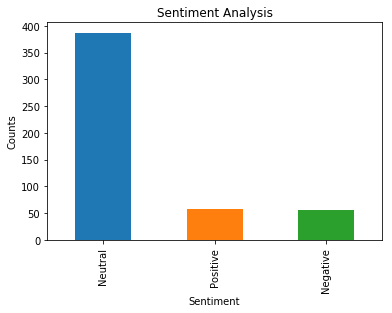

In [19]:
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df['analysis'].value_counts().plot(kind = 'bar')
plt.show()